In [1]:
import numpy as np
import pandas as pd
import multiprocessing as mp
from my.data.basic_func import get_basic_data
from my.data.meta_api import get_before_trade_info
from datetime import time as dtime
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from optuna.integration import LightGBMPruningCallback
import optuna

In [2]:
def get_dates(start_dt, end_dt):
    table_name = "bond_calendar"
    df = get_basic_data(20230728, table_name)
    cal_list = df[df.exchmarket == "NIB"].trade_dt
    dates = []
    for i in cal_list:
        if (int(i) >= start_dt) & (int(i) <= end_dt):
            dates.append(int(i))
    dates_not_in = [ 20220129, 20220130, 20221107, 20221202, 20221216,
        20221219, 20221231, 20230120, 20230128, 20230129, 20230215, 20230216,  20230410, 20230423, 20230506, 20230517, 20230625]
    for j in dates_not_in:
        if j in dates:
            dates.remove(j)
    return dates


def resample(df, period):
    # period = 60s
    df = df.resample(period).last()
    return df


def label(series, method):
    if method == "logdiff":
        return np.log(series).diff() * 1e4
    if method == "diff":
        return np.diff(series)


def clean_ourliers(df):
    df[df["ylabel"] > 10] = 0  # clean outliers
    return df



def read_data(start_dt, end_dt):
    dates = get_dates(start_dt, end_dt)
    import factors
    df = factors.get_factors('220220.IB', 20230418)  # to get the shape of factors
    a, b = np.shape(df)
    Fx = np.zeros((len(dates), 300, b))  # 300 mins every day a= 300
    Fy = np.zeros((len(dates), 300))
    for i in range(len(dates)):
        date = dates[i]
        # print(date)
        df_mc = get_before_trade_info(date, "bond_main_contract")
        mc_dict = dict(zip(df_mc.label, df_mc.securityid))
        if "CDB10Y01.IB" in mc_dict:
            bond_code = mc_dict["CDB10Y01.IB"]
        else:
            bond_code = "220220.IB"
        df = factors.get_factors(bond_code, date)
        # df = df.resample("60s").last()
        df["ylabel"] = label(df["midprice"], "logdiff")
        # delete data between 11:30 and 13:30
        df = df.drop(df[(df.index.time >= dtime(11, 30, 00)) & (df.index.time < dtime(13, 30, 00))].index)
        df["mins"] = [i for i in range(len(df))]
        Fy[i, :] = df.ylabel
        del df["ylabel"]
        del df["midprice"]
        Fx[i, :] = df
    return Fx, Fy


def split(Fx, Fy, period, dates):
    kk = round(len(dates)/period)
    a, b, c= np.shape(Fx)
    train_xlist = np.zeros((kk, period*300, c))
    train_ylist = np.zeros((kk, period*300))
    test_xlist = np.zeros((kk, 300, c))
    test_ylist = np.zeros((kk, 300))

    for i in range(kk):
        train = list(range(i, period+i))
        train_x = np.vstack(Fx[train,:])
        train_y = np.hstack(Fy[train,:])
        test_x = Fx[period+i]
        test_y = Fy[period+i]
        train_xlist[i, :, :] = train_x
        train_ylist[i, : ] = train_y
        test_xlist[i,:,:] = test_x
        test_ylist[i,:] = test_y
    return train_xlist, train_ylist, test_xlist, test_ylist

In [ ]:
Fx, Fy = read_data(20220101,20221231)

In [4]:
start_dt = 20220101
end_dt = 20221231
dates = get_dates(start_dt, end_dt)
# train_xlist, train_ylist, test_xlist, test_ylist = split(Fx, Fy, 200, dates)

period = 100

kk = len(dates) - period -1 
a, b, c= np.shape(Fx)
train_xlist = np.zeros((kk, period*300, c))
train_ylist = np.zeros((kk, period*300))
test_xlist = np.zeros((kk, 300, c))
test_ylist = np.zeros((kk, 300))

for i in range(kk):
    train = list(range(i, period+i))
    train_x = np.vstack(Fx[train,:])
    train_y = np.hstack(Fy[train,:])
    test_x = Fx[period+i]
    test_y = Fy[period+i]
    # delete nan or infs
    train_y[(train_y>100) |  (train_y<-100)] = 0
    train_y[np.isnan(train_y)] = 0

    test_y[(test_y>100) |  (test_y<-100)] = 0
    test_y[np.isnan(test_y)] = 0

    train_xlist[i, :, :] = train_x
    train_ylist[i, : ] = train_y
    test_xlist[i,:,:] = test_x
    test_ylist[i,:] = test_y

In [5]:
i = 1
X_train = train_xlist[i]
X_test = test_xlist[i]
y_train = train_ylist[i]
y_test = test_ylist[i]
# y_train = y_train.ravel()
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [6]:
my_model = lgb.LGBMRegressor(objective="regression", num_leaves=100, learning_rate=0.05, n_estimators=20, verbosity=2)
my_model.fit(X_train, y_train, verbose=False)
# my_model.fit(train_X[1].transpose(), train_y[1], verbose=False)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.107133
[LightGBM] [Debug] init for col-wise cost 0.000009 seconds, init for row-wise cost 0.002598 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 10
[LightGBM] [Info] Start training from score -0.000691
[LightGBM] [Debug] Trained a tree with leaves = 100 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 100 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 100 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 100 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 100 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 100 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 100

LGBMRegressor(learning_rate=0.05, n_estimators=20, num_leaves=100,
              objective='regression', verbosity=2)

In [8]:
predictions = my_model.predict(X_test)
# 对模型的预测结果进行评判（平均绝对误差）
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 0.24564963122662004


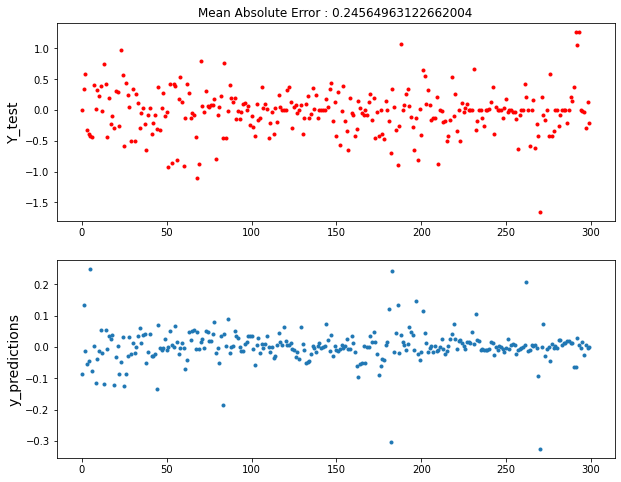

In [9]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
ax[0].plot(y_test,'.',color='r')
ax[0].set_ylabel('Y_test',fontsize=14)
ax[0].set_title("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))
ax[1].plot(predictions,'.')
ax[1].set_ylabel('y_predictions',fontsize=14)
fig.savefig('regression.jpg', dpi = 300)

In [83]:
def objective(trial, X, y):
    # 参数网格
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
        "random_state": 2021,
    }
    # 5折交叉验证
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # LGBM建模
        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],
        )
        # 模型预测
        preds = model.predict_proba(X_test)
        # 优化指标logloss最小
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Regression")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

In [10]:
# 超参训练
def lgb_optuna(trial, train_x, train_y, test_x, test_y):
    param = {
        'num_leaves': trial.suggest_int(
            'num_leaves', 10, 1000
        ),
        'max_bin':100,
        'min_data_in_leaf': trial.suggest_int(
            'min_data_in_leaf', 100, 1000
        ),
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'bagging_fraction': trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        'bagging_freq':5,
        'bagging_seed':66,
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
        'feature_fraction_seed': 66,
        # loss
        'lambda_l1': trial.suggest_int("lambda_l2", 0, 100, step=5),
        'lambda_l2': trial.suggest_int("lambda_l2", 0, 100, step=5),
        'min_gain_to_split': trial.suggest_float("min_gain_to_split", 0, 15),
        # greedy
        'min_sum_hessian_in_leaf':   trial.suggest_discrete_uniform(
            'min_sum_hessian_in_leaf', 0.55 , 20.0, 0.1
        ),
        # object-metric
        'objective': 'regression',
        'metric': 'rmse',
        'n_jobs':25,
        'boosting': 'gbdt',
        'verbose': 1,
        'early_stopping_rounds':50,
        'n_estimators': 500
    }

    model = lgb.LGBMRegressor(**param)  
    model.fit(train_x,  train_y,
            eval_set=[
                (train_x,  train_y), (test_x, test_y)
            ],
            early_stopping_rounds=50,     
            verbose=200
            )
    pred_ = model.predict(test_x)
    loss = np.sqrt(mean_squared_error(test_x, np.round(np.expm1(pred_))))
    return loss


# my_model = lgb.LGBMRegressor(objective="regression", num_leaves=10, learning_rate=0.1, n_estimators=20, verbosity=2)
# my_model.fit(X_train, y_train, verbose=False)
# # my_model.fit(train_X[1].transpose(), train_y[1], verbose=False)

In [12]:
study = optuna.create_study(direction='minimize')
func = lambda trial: lgb_optuna(trial, X_train, y_train, X_test, y_test)
study.optimize(func, n_trials=10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-08-11 17:26:32,649] A new study created in memory with name: no-name-3da412c6-6c7e-4072-b7da-a3e06e16a7ea
[W 2023-08-11 17:26:32,755] Trial 0 failed with parameters: {'num_leaves': 953, 'min_data_in_leaf': 316, 'learning_rate': 0.2672123342757945, 'bagging_fraction': 0.2, 'feature_fraction': 0.7, 'lambda_l2': 70, 'min_gain_to_split': 8.240949845588299, 'min_sum_hessian_in_leaf': 17.450000000000003} because of the following error: ValueError('y_true and y_pred have different number of output (10!=1)').
Traceback (most recent call last):
  File "/home/liuyuqing/.local/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-12-1a2536615963>", line 2, in <lambda>
    func = lambda trial: lgb_optuna(trial, X_train, y_train, X_test, y_test)
  File "<ipython-input-10-2aa04ba8c903>", line 44, in lgb_optuna
    loss = np.sqrt(mean_squared_error(test_x, np.round(np.expm1(pred_))))
  File "/usr/local/python3.

[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] min_gain_to_split is set=8.240949845588299, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.240949845588299
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] min_data_in_leaf is set=316, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=316
[LightGBM] [Warning] min_sum_hessian_i

ValueError: y_true and y_pred have different number of output (10!=1)